#    Hyperparameter Tuning for Intent Classification using LSTM with Attention Mechanism
This notebook is a part of the Ultimate AI Challenge. In this notebook, we train a LSTM with Attention Mechanism for Intent Classification on the ATIS dataset. We use Optuna for hyperparameter tuning and MLflow for experiment tracking and model registry. We also use ONNX for model export and inference. The notebook is divided into the following sections:
1. Data Preparation
2. Hyperparameter Tuning
3. Model Training and Evaluation
4. Visualize the results
5. Model Export, Registry, Model Loading and Inference


In [6]:
import sys
from sklearn.model_selection import KFold
import torch.nn as nn
from machine_learning.IntentClassifierLSTMWithAttention import IntentClassifierLSTMWithAttention
from machine_learning.IntentTokenizer import IntentTokenizer
import torch.optim as optim
import pandas as pd
import torch
from torch.utils.data import DataLoader
from machine_learning.model_utils import train, evaluate, predict, get_or_create_experiment
import optuna
import logging
import mlflow
from optuna.visualization import plot_optimization_history
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*setuptools.*")

device=torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Data Preparation
Steps:
1. Load the data
2. Tokenize the data
3. Create a PyTorch Dataset
4. Create a PyTorch DataLoader

In [2]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

train_df = pd.read_csv('data/atis/train.tsv', sep='\t', header=None, names=["text", "label"])
test_df = pd.read_csv('data/atis/test.tsv', sep='\t', header=None, names=["text", "label"])
tokenizer = IntentTokenizer(train_df)

# define constants and hyperparameters
vocab_size=tokenizer.max_vocab_size+1
output_dim=len(tokenizer.le.classes_)
batch_size = 32
num_epochs = 5

train_data = tokenizer.process_data(train_df, device=device)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
print("Number of training samples:", train_data.tensors[0].size())
print("Number of training batches:", len(train_loader))

test_data = tokenizer.process_data(test_df, device=device)
print("Number of test samples:", test_data.tensors[0].size())
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
print("Number of test batches:", len(test_loader))

inside IntentTokenizer
Vocabulary Size: 890
Encoding labels for the first time and adding unknown class.
Label Encoding: {'abbreviation': 0, 'aircraft': 1, 'aircraft+flight+flight_no': 2, 'airfare': 3, 'airfare+flight_time': 4, 'airline': 5, 'airline+flight_no': 6, 'airport': 7, 'capacity': 8, 'cheapest': 9, 'city': 10, 'distance': 11, 'flight': 12, 'flight+airfare': 13, 'flight_no': 14, 'flight_time': 15, 'ground_fare': 16, 'ground_service': 17, 'ground_service+ground_fare': 18, 'meal': 19, 'quantity': 20, 'restriction': 21, '<unknown>': 22}
Number of training samples: torch.Size([4634, 46])
Number of training batches: 145
Number of test samples: torch.Size([850, 30])
Number of test batches: 27


Sample training data:
tensor([[ 10,  69,   1,  38,   2,   9,  66, 397,  86,  17,  81,  16,  13,  66,
         525,  16,   4,  35,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  6,   3,  26,  58,   2,  19,   1,  23,   5,  72,  35,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  6,  21,   4, 398, 176,  16,  11,  15,  39,   4, 526,  86,   7,  33,
          32,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [ 49, 270,   2, 177,   1, 123,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0, 

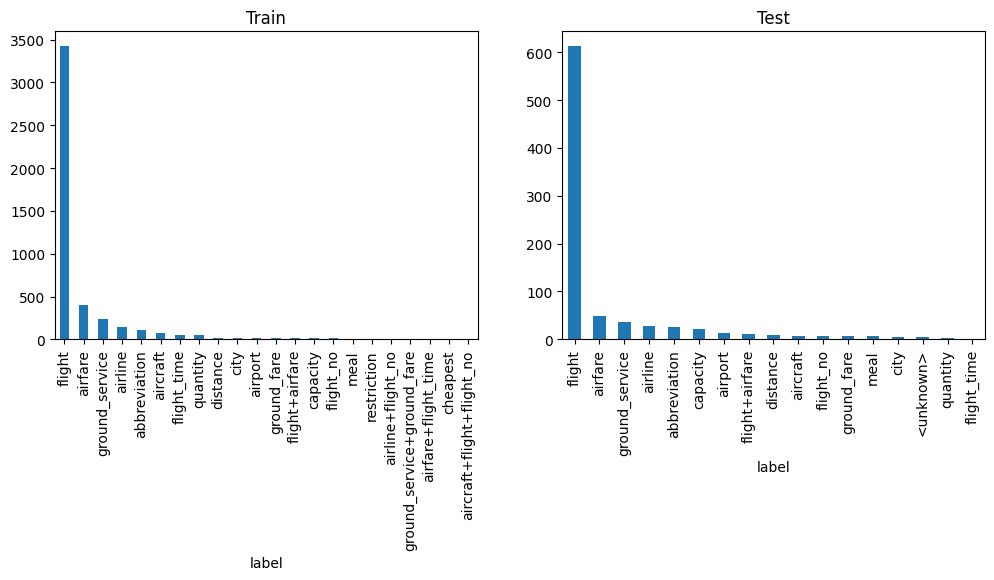

In [3]:
# Visualize the data
print("Sample training data:")
print(train_data.tensors[0][:5])

# Plot the class distribution ins test and train
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
train_df.label.value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("Train")
test_df.label.value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("Test")
plt.show()

## Hyperparameter Tuning
The Model that we are using for the hyperparameter tuning is the IntentClassifierLSTMWithAttention. The hyperparameters that we are tuning are:
1. Learning rate : 1e-3 to 1e-1
2. Hidden dimension : 32, 64, 128, 256
3. Embedding dimension : 64, 128, 256, 512
4. Dropout rate : 0.1 to 0.5
5. Weight decay : 1e-6 to 1e-3

The objective function is the average validation accuracy over 5 folds. The best model is the one with the highest average validation accuracy.

In [4]:
def log_hyperparameters(trial):
    # Log hyperparameters
    
    mlflow.log_param("lr", trial.params["lr"])
    mlflow.log_param("hidden_dim", trial.params["hidden_dim"])
    mlflow.log_param("embedding_dim", trial.params["embedding_dim"])
    mlflow.log_param("dropout_rate", trial.params["dropout_rate"])
    mlflow.log_param("weight_decay", trial.params["weight_decay"])
    print(f'lr: {trial.params["lr"]}, hidden_dim: {trial.params["hidden_dim"]}, embedding_dim: {trial.params["embedding_dim"]}, dropout_rate: {trial.params["dropout_rate"]}, weight_decay: {trial.params["weight_decay"]}')

    return

def log_metrics(trial, accuracy):
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    return
def objective(trial):
    with mlflow.start_run():
        # Suggest hyperparameters
        lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)
        hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128, 256])
        embedding_dim = trial.suggest_categorical("embedding_dim", [64, 128, 256, 512])
        dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
        criterion = nn.CrossEntropyLoss()
        log_hyperparameters(trial)
        # Model, loss, and optimizer
        # model = IntentClassifierLSTM(cfg.vocab_size, embedding_dim, hidden_dim, cfg.output_dim,dropout_rate).to(device)
        model = IntentClassifierLSTMWithAttention(vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        fold_val_acc = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
            # Prepare fold data
            train_data_subset = tokenizer.process_data(train_df.loc[train_idx,:], device=device)
            val_data_subset = tokenizer.process_data(train_df.loc[val_idx,:], device=device)
            train_subset_loader = DataLoader(train_data_subset, batch_size=batch_size, shuffle=True)
            val_subset_loader = DataLoader(val_data_subset, batch_size=batch_size, shuffle=False)
            fold_loss = train(model, optimizer, criterion, train_subset_loader, num_epochs)
            val_accuracy = evaluate(model,  criterion, val_subset_loader, data_type="Validation")
            print(f'Fold: {fold + 1}, Training Loss: {fold_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            fold_val_acc.append(val_accuracy)
        average_val_acc = sum(fold_val_acc) / len(fold_val_acc)
        print(f'Average validation accuracy: {average_val_acc:.4f}')
        log_metrics(trial, average_val_acc)
    return average_val_acc

## Optuna Experiments
Create an experiment in MLflow and run the hyperparameter tuning experiment. The best model is the one with the highest average validation accuracy.

In [7]:
experiment_id = get_or_create_experiment("IntentClassifierLSTMWithAttention2")

mlflow.set_experiment(experiment_id=experiment_id)
study_name = "IntentClassifierLSTMWithAttention"
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,load_if_exists=True,direction="maximize")
study.optimize(objective, n_trials=10)
best_trial = study.best_trial

lr: 0.001564255410763439, hidden_dim: 32, embedding_dim: 128, dropout_rate: 0.3909687711135753, weight_decay: 1.928612343790645e-06
Epoch [1/5], Loss: 1.9981, Accuracy: 0.5851
Epoch [2/5], Loss: 0.6744, Accuracy: 0.8670
Epoch [3/5], Loss: 0.4192, Accuracy: 0.9045
Epoch [4/5], Loss: 0.3262, Accuracy: 0.9261
Epoch [5/5], Loss: 0.2646, Accuracy: 0.9326
Validation Loss: 0.1715
Validation Accuracy: 0.9504
Fold: 1, Training Loss: 0.2646, Validation Accuracy: 0.9504
Epoch [1/5], Loss: 0.2110, Accuracy: 0.9490
Epoch [2/5], Loss: 0.1642, Accuracy: 0.9612
Epoch [3/5], Loss: 0.1407, Accuracy: 0.9663
Epoch [4/5], Loss: 0.1236, Accuracy: 0.9668
Epoch [5/5], Loss: 0.1041, Accuracy: 0.9719
Validation Loss: 0.1163
Validation Accuracy: 0.9730
Fold: 2, Training Loss: 0.1041, Validation Accuracy: 0.9730
Epoch [1/5], Loss: 0.1187, Accuracy: 0.9657
Epoch [2/5], Loss: 0.0892, Accuracy: 0.9763
Epoch [3/5], Loss: 0.0842, Accuracy: 0.9795
Epoch [4/5], Loss: 0.0665, Accuracy: 0.9830
Epoch [5/5], Loss: 0.0591, A

## Best Model Training and Evaluation
Tune the best model with a larger number of epochs and evaluate it on the test set.

In [8]:
with mlflow.start_run(experiment_id=experiment_id):
    # Log the best parameters
    mlflow.log_params(best_trial.params)

    # Train the model using best parameters
    model = IntentClassifierLSTMWithAttention(
        vocab_size,
        best_trial.params['embedding_dim'],
        best_trial.params['hidden_dim'],
        output_dim,
        best_trial.params['dropout_rate']
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=best_trial.params['lr'],
                           weight_decay=best_trial.params['weight_decay'])
    train_loss = train(model, optimizer, nn.CrossEntropyLoss(), train_loader, 10)
    test_accuracy = evaluate(model, nn.CrossEntropyLoss(), test_loader, data_type="Test")
    print(f'Test Accuracy: {test_accuracy:.4f}')
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("train_loss", train_loss)
    mlflow.pytorch.log_model(model, f"best_model_{study.study_name}")

Epoch [1/10], Loss: 1.6801, Accuracy: 0.6718
Epoch [2/10], Loss: 0.4333, Accuracy: 0.9197
Epoch [3/10], Loss: 0.2553, Accuracy: 0.9469
Epoch [4/10], Loss: 0.1892, Accuracy: 0.9599
Epoch [5/10], Loss: 0.1253, Accuracy: 0.9715
Epoch [6/10], Loss: 0.0975, Accuracy: 0.9767
Epoch [7/10], Loss: 0.0858, Accuracy: 0.9801
Epoch [8/10], Loss: 0.0722, Accuracy: 0.9827
Epoch [9/10], Loss: 0.0564, Accuracy: 0.9838
Epoch [10/10], Loss: 0.0449, Accuracy: 0.9892
Test Loss: 0.2989
Test Accuracy: 0.9482
Test Accuracy: 0.9482


## Visualize the results
Optuna provides a number of visualizations to analyze the results of the hyperparameter tuning experiment. We can use these visualizations to analyze the results of the hyperparameter tuning experiment.

/var/folders/jk/m7rkkh0s0hjbspb28jt26mlw0000gn/T/ipykernel_8909/4237326169.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


AttributeError: 'Axes' object has no attribute 'show'

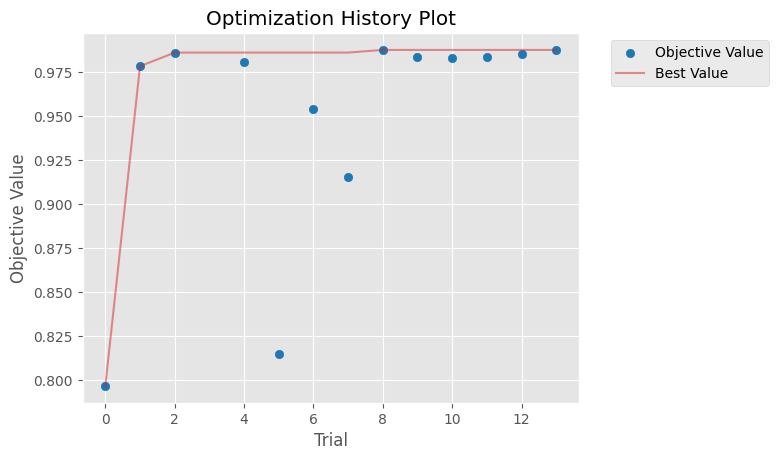

In [9]:
# Visualize the optimization history
# Generate the Optuna plot
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
fig.show()

In [ ]:
fig=optuna.visualization.matplotlib.plot_parallel_coordinate(study)
fig.show()

In [ ]:
fig = optuna.visualization.matplotlib.plot_contour(study)
fig.show()

## Save the model and check model Serving

In [ ]:
model_name = "best_ICELSTMAmodel"
# Load the trained model and tokenizer from saved files
model_serve = torch.load(f"models/{model_name}.pth").to(device)
tokenizer = tokenizer = IntentTokenizer.load_state(IntentTokenizer,f"models/{model_name}_tokenizer.pickle", f"models/IntentClassifierLSTMWithAttention_le.pickle")
max_query_length = 50
query_text = "what airlines off from love field between 6 and 10 am on june sixth"
query = pd.DataFrame({"text": [query_text]})
prediction = predict(model_serve, query,tokenizer,device)
print(f"Predicted label: {prediction}")